In [141]:
"""
Identify wildfire events with >= 1% pre-fire aspen forest cover across western U.S. ecoregions

Data sources
    - Wildfire perimeters: NIFC Interagency Final Wildfire Perimeters
    - Landcover: LANDFIRE Existing Vegetation Type (EVT) ca. 2016
    
Author: maxwell.cook@colorado.edu
"""

import os, sys, time, gc
import geopandas as gpd
import rioxarray as rxr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [ ]:
# load the fire data (NIFC) and handle duplicate entries

In [9]:
# Load the NIFC perimeters
fp = os.path.join(projdir,'data/spatial/raw/NIFC/nifc-interagency_2012_to_2023.gpkg')
events = gpd.read_file(fp)
print(f"There are [{len(events)}] NIFC perimeters.\n{events.columns}")

There are [34595] NIFC perimeters.
Index(['OBJECTID', 'MAP_METHOD', 'DATE_CUR', 'COMMENTS', 'GEO_ID', 'IRWINID',
       'UNQE_FIRE_', 'FIRE_YEAR', 'LOCAL_NUM', 'INCIDENT', 'UNIT_ID',
       'POO_RESP_I', 'FEATURE_CA', 'GIS_ACRES', 'USER_NAME', 'SOURCE',
       'AGENCY', 'FIRE_YEAR_', 'Shape__Are', 'Shape__Len', 'FORID', 'OTHERID',
       'geometry'],
      dtype='object')


In [4]:
# tidy the columns.
events = events[['OBJECTID','MAP_METHOD','GEO_ID','IRWINID','FIRE_YEAR',
                 'INCIDENT','FEATURE_CA','GIS_ACRES','geometry']]
# Check on the burned area distribution
events['GIS_ACRES'].describe()

count    3.459500e+04
mean     5.686211e+04
std      9.776046e+05
min      0.000000e+00
25%      4.720000e+00
50%      3.301000e+01
75%      2.833400e+02
max      1.314430e+08
Name: GIS_ACRES, dtype: float64

In [14]:
# Keep fires greater than at least 1 acres (excludes potential map errors)
events = events[events['GIS_ACRES'] >= 100]
print(f"Keeping [{len(events)}] fires >= 100 acres.")

# Check for duplicates (different mapping methods)
n_dup = events.duplicated(subset='IRWINID').sum()
print(f"{n_dup} [{round(n_dup/len(events)*100, 2)} %] of fires have a duplicate IRWINID.\n")

Keeping [12282] fires >= 100 acres.
6071 [49.43 %] of fires have a duplicate IRWINID.



In [15]:
# Resolve duplicate fire perimeters
def resolve_duplicates(group):
    """ If there are duplicates, keep the record labeled 'Final Wildfire Perimeter'. 
    If no such record exists, keep one of the records (first occurrence). """
    if 'Wildfire Final Fire Perimeter' in group['FEATURE_CA'].values:
        return group[group['FEATURE_CA'] == 'Wildfire Final Fire Perimeter'].iloc[0]  # Keep 'Final' perimeter
    else:
        return group.iloc[0]  # If no 'Final' perimeter, keep the first record

# Isolate duplicate records
dups = events[events['IRWINID'].duplicated(keep=False)]  # Keep all duplicates
print(f"Number of unique duplicates: {len(dups['IRWINID'].unique())}/{len(dups)}")

# Apply the function to groups of duplicates
resolved_df = dups.groupby('IRWINID').apply(resolve_duplicates).reset_index(drop=True)
print(f"Number of remaining fires after removing duplicates: {len(resolved_df)}")

# Combine the resolved duplicates with the non-duplicates
non_dups = events[~events['IRWINID'].duplicated(keep=False)]  # keep only non-duplicates
events_c = pd.concat([non_dups, resolved_df], ignore_index=True) # merge back (clean data)

print(f"\nThere are {len(events_c)} unique fire perimeters after resolving duplicates.")

del dups, resolved_df, non_dups, events
gc.collect() # clean up

Number of unique duplicates: 263/6334
Number of remaining fires after removing duplicates: 262

There are 6210 unique fire perimeters after resolving duplicates.


0

In [ ]:
# Join to western U.S. ecoregions

In [16]:
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','NA_L3CODE','geometry']].rename(columns={'NA_L3NAME': 'na_l3name', 'NA_L3CODE': 'na_l3code'})
ecol3.columns

Index(['na_l3name', 'na_l3code', 'geometry'], dtype='object')

In [17]:
# Identify the US EPA Level III ecoregion based on centroid of fire perimeter
centroids = events_c.copy() # make a copy of the fire data
centroids.geometry = centroids.geometry.centroid # use the centroid for joining to ecoregions
if not centroids.crs == ecol3.crs:
    print("CRS mismatch, fixing it !")
    centroids = centroids.to_crs(proj)
    ecol3 = ecol3.to_crs(proj)

# Perform the overlay analysis
events_west = gpd.overlay(centroids, ecol3, how='intersection') # find overlaps

print(f"There are {len(events_west)} fire events across western U.S. ecoregions in CONUS (2012-2023).")
print(f"Data columns:\n{events_west.columns}")

There are 4321 fire events across western U.S. ecoregions in CONUS (2012-2023).
Data columns:
Index(['OBJECTID', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR', 'INCIDENT',
       'FEATURE_CA', 'GIS_ACRES', 'na_l3name', 'na_l3code', 'geometry'],
      dtype='object')


In [18]:
# Replace the centroid geometry with the fire perimeter
events_west = gpd.GeoDataFrame(
    pd.merge(events_west[['OBJECTID','na_l3name']], events_c, left_on='OBJECTID', right_on='OBJECTID', how="left")
)
print(f"Geometry set to fire perimeters: {events_west.geom_type.unique()}")

Geometry set to fire perimeters: ['MultiPolygon']


In [73]:
# Filter to 2016-2023 fires
events_west['FIRE_YEAR'] = events_west['FIRE_YEAR'].astype(int)
events_west = events_west[events_west['FIRE_YEAR'] >= 2016]

In [74]:
# save this file out.
out_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-interagency_2016_to_2023_west.gpkg')
events_west.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/NIFC/nifc-interagency_2016_to_2023_west.gpkg


In [75]:
# Calculate zonal statistics from the LANDFIRE EVT
fp = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
lf_evt = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
# Grab some raster metadata
shp, gt, wkt, nd = lf_evt.shape, lf_evt.spatial_ref.GeoTransform, lf_evt.rio.crs, lf_evt.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {lf_evt[0].dtype}")
gc.collect() # clean up

Shape: (97283, 154207); 
GeoTransform: -2362425.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


623

In [76]:
# Calculate zonal stats for the wildfire perimeters.
t0 = time.time()

# Add a small buffer to wildfire perimeters
# *Accounting for edge effects
buffer = 90  # meters
events_west = events_west.copy() # make a copy of the original data
events_west['geometry'] = events_west['geometry'].buffer(buffer)
print(f"Buffered fire perimeters by {buffer} meters.")

# Crop the raster by the fire bounds (with small buffer)
bounds = events_west.total_bounds
lf_evt_crop = lf_evt.rio.clip_box(
    minx=bounds[0]+1000, # +1000 meters for a small buffer on main extent
    miny=bounds[1]+1000, 
    maxx=bounds[2]+1000, 
    maxy=bounds[3]+1000
)

# see __functions.py
sampled = compute_band_stats(events_west, lf_evt_crop, 'OBJECTID', attr='VALUE')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del lf_evt_crop, lf_evt, bounds
gc.collect()  # clean up

sampled.head(3) # check the results

Buffered fire perimeters by 90 meters.
Total elapsed time: 5.79 minutes.

~~~~~~~~~~



,OBJECTID,VALUE,count,total_pixels,pct_cover
0,5,7011,4119,20187,20.404221
1,5,7016,19,20187,0.094120
2,5,7051,741,20187,3.670679


In [77]:
# load the EVT lookup table to join vegetation type information
fp = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(fp)
lookup.columns

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')

In [80]:
# Join the lookup table with the fire summary
fire_evt = pd.merge(sampled, lookup, on='VALUE', how='left')
fire_evt.rename(columns={'OBJECTID': 'Fire_ID', 'VALUE': 'EVT'}, inplace=True)
fire_evt.head(3)

,Fire_ID,EVT,count,total_pixels,pct_cover,EVT_NAME,LFRDB,EVT_FUEL,EVT_FUEL_N,EVT_LF,...,SAF_SRM,EVT_ORDER,EVT_CLASS,EVT_SBCLS,R,G,B,RED,GREEN,BLUE
0,5,7011,4119,20187,20.404221,Rocky Mountain Aspen Forest and Woodland,7011.0,2011.0,Tr Rocky Mountain Aspen Forest and Woodland,Tree,...,SAF 217: Aspen,Tree-dominated,Open tree canopy,Deciduous open tree canopy,192,255,138,0.752941,1.0,0.541176
1,5,7016,19,20187,0.094120,Colorado Plateau Pinyon-Juniper Woodland,7016.0,2016.0,Tr Colorado Plateau Pinyon-Juniper Woodland,Tree,...,SRM 504: Juniper-Pinyon Pine Woodland,Tree-dominated,Open tree canopy,Evergreen open tree canopy,121,255,94,0.474510,1.0,0.368627
2,5,7051,741,20187,3.670679,Southern Rocky Mountain Dry-Mesic Montane Mixe...,7051.0,2051.0,Tr Southern Rocky Mountain Dry-Mesic Montane M...,Tree,...,SAF 210: Interior Douglas-Fir,Tree-dominated,Closed tree canopy,Evergreen closed tree canopy,0,51,0,0.000000,0.2,0.000000


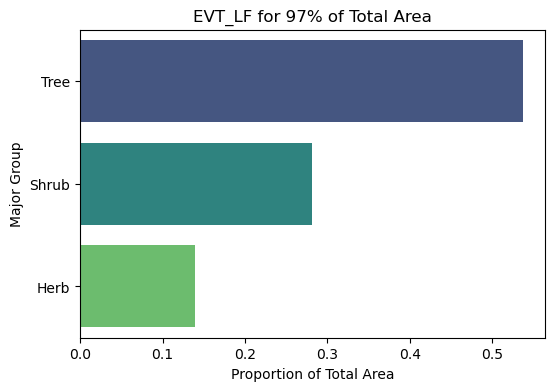

In [95]:
# Summarize total area by major group
prevalence = fire_evt.groupby('EVT_LF')['count'].sum().reset_index()
prevalence['proportion'] = prevalence['count'] / prevalence['count'].sum()
prevalence = prevalence.sort_values('proportion', ascending=False)
prevalence['prop_csum'] = prevalence['proportion'].cumsum()
top_groups = prevalence[prevalence['prop_csum'] <= 0.97]

# Plot with annotations
plt.figure(figsize=(6, 4))
ax = sns.barplot(x='proportion', y='EVT_LF', data=top_groups, palette='viridis')
plt.xlabel('Proportion of Total Area')
plt.ylabel('Major Group')
plt.title('EVT_LF for 97% of Total Area')
plt.show()

In [96]:
# save this file out.
out_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-interagency_2016_to_2023-LFEVT_Stats.csv')
fire_evt.to_csv(out_fp)
print(f"Saved file to {out_fp}")

Saved file to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/NIFC/nifc-interagency_2016_to_2023-LFEVT_Stats.csv


In [98]:
# Identify fires with >= 1% aspen forest cover
aspen_evt = fire_evt[fire_evt['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(f"Aspen EVT classes: \n{aspen_evt}")

Aspen EVT classes: 
['Rocky Mountain Aspen Forest and Woodland'
 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland'
 'Northwestern Great Plains Aspen Forest and Parkland']


In [120]:
# identify fires with any aspen
aspen_fires = fire_evt[fire_evt['EVT_NAME'].isin(aspen_evt)]
pct_aspen = round(len(aspen_fires['Fire_ID'].unique())/len(fire_evt['Fire_ID'].unique())*100,2)
print(f"\n{len(aspen_fires)} [{pct_aspen}%] fires w/ any aspen across western U.S. ecoregions (2016-2023).\n")

# filter fires where "pct_aspen" >= 1%
aspen_fires = aspen_fires.groupby('Fire_ID')['pct_cover'].sum().reset_index() # get the sum of aspen classes
aspen_fires = aspen_sum[aspen_sum['pct_cover'] >= 1] # retain fires with >= 1% 
aspen_fires = aspen_fires[['Fire_ID','pct_cover']].rename(columns={'pct_cover': 'pct_aspen'}) 

# get the percentage of fires with > 1% aspen
pct_aspen = round(len(aspen_fires['Fire_ID'].unique())/len(fire_evt['Fire_ID'].unique())*100,2)
print(f"\n{len(aspen_fires)} [{pct_aspen}%] fires w/ >= 1% aspen.\n")


1285 [25.8%] fires w/ any aspen across western U.S. ecoregions (2016-2023).


267 [7.01%] fires w/ >= 1% aspen.



In [121]:
# Join aspen percent to the spatial data.
events_west.rename(columns={'OBJECTID': 'Fire_ID'}, inplace=True)
events_west_aspen = pd.merge(events_west, aspen_fires, on='Fire_ID', how='inner')
events_west_aspen = events_west_aspen.to_crs(proj)  # ensure the correct projection before exporting
events_west_aspen.columns

Index(['Fire_ID', 'na_l3name', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR',
       'INCIDENT', 'FEATURE_CA', 'GIS_ACRES', 'geometry', 'pct_aspen'],
      dtype='object')

In [123]:
# Check for remaining duplicates
print(f"There are {events_west_aspen.duplicated(subset='IRWINID').sum()} duplicate IRWINIDs.")

There are 0 duplicate IRWINIDs.


In [125]:
# Check for remaining duplicates on year+fire name
events_west_aspen['YEAR_NAME'] = events_west_aspen['FIRE_YEAR'].astype(str) + events_west_aspen['INCIDENT'].astype(str) + events_west_aspen['na_l3name'].astype(str)
print(f"There are {events_west_aspen.duplicated(subset='YEAR_NAME').sum()} duplicate Fire Year/Fire Name combinations.")

There are 3 duplicate Fire Year/Fire Name combinations.


In [127]:
duplicates = events_west_aspen[events_west_aspen['YEAR_NAME'].duplicated(keep=False)]  # Keep all duplicates
duplicates = duplicates.sort_values(by=['INCIDENT'])
duplicates[['Fire_ID','FIRE_YEAR','INCIDENT','YEAR_NAME','GIS_ACRES','MAP_METHOD','pct_aspen']].head(len(duplicates))

,Fire_ID,FIRE_YEAR,INCIDENT,YEAR_NAME,GIS_ACRES,MAP_METHOD,pct_aspen
123,25950,2017,Boundary,2017BoundaryArizona/New Mexico Mountains,17817.96,Infrared Interpretation,1.292995
140,29666,2017,Boundary,2017BoundaryArizona/New Mexico Mountains,17804.88,Other Agency Digital,1.294428
185,48977,2022,Michaud Creek,2022Michaud CreekNorthern Basin and Range,343.40,Unknown,3.408459
221,80116,2022,Michaud Creek,2022Michaud CreekNorthern Basin and Range,343.54,Mixed Methods,3.408933
198,70102,2018,Ryan,2018RyanSouthern Rockies,28585.43,Mixed Methods,9.295722
252,41932,2018,Ryan,2018RyanSouthern Rockies,28243.65,Infrared Interpretation,9.220808


In [129]:
# Handle remaining duplicate fire boundaries (keep the largest)
duplicates = duplicates.sort_values(by=['GIS_ACRES'], ascending=False)
resolved_df = duplicates.drop_duplicates(subset='INCIDENT', keep='first')
# Check the results
print(resolved_df[['Fire_ID','FIRE_YEAR','INCIDENT','GIS_ACRES','pct_aspen']].head(len(resolved_df)))

# Merge back with the original dataframe
non_dups = events_west_aspen[~events_west_aspen['YEAR_NAME'].duplicated(keep=False)]  # keep only non-duplicates
events_west_aspen = pd.concat([non_dups, resolved_df], ignore_index=True) # merge back
print(f"There are {len(events_west_aspen)} after resolving the last duplicates.")

     Fire_ID  FIRE_YEAR       INCIDENT  GIS_ACRES  pct_aspen
198    70102       2018           Ryan   28585.43   9.295722
123    25950       2017       Boundary   17817.96   1.292995
221    80116       2022  Michaud Creek     343.54   3.408933
There are 264 after resolving the last duplicates.


In [131]:
# Save this file out
out_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-interagency_2016_to_2023-LFEVT_aspen.gpkg')
events_west_aspen.to_file(out_fp)
print(f"Saved file to {out_fp}")

Saved file to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/NIFC/nifc-interagency_2016_to_2023-LFEVT_aspen.gpkg


In [ ]:
# Map of aspen fires

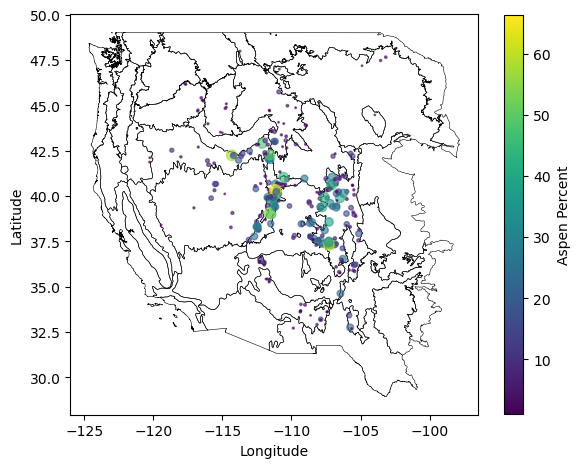

In [135]:
# Load the state boundaries
states = gpd.read_file(os.path.join(maindir,'data/boundaries/political/TIGER/tl19_us_states_west_nad83.gpkg'))

states = states.to_crs(4326)
ecol3 = ecol3.to_crs(4326)

# Generate centroids
centroid = events_west_aspen.copy()
centroid = centroid.to_crs(4326)
centroid['geometry'] = centroid.geometry.centroid
centroid['size'] = centroid['pct_aspen'] * 10  # Adjust the scaling factor as necessary

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

ecol3.plot(ax=ax, edgecolor='black', linewidth=0.4, color='none')
centroid.plot(
    ax=ax, markersize=centroid['pct_aspen'], 
    column='pct_aspen', cmap='viridis', 
    legend=False, alpha=0.6)

# Manually add colorbar
norm = matplotlib.colors.Normalize(vmin=centroid['pct_aspen'].min(), vmax=centroid['pct_aspen'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Adjust the size of the colorbar using the `shrink` parameter
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Aspen Percent')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/Figure1_Aspen-Fires_NIFC_2016to2023_EVT.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
events_west_aspen.columns

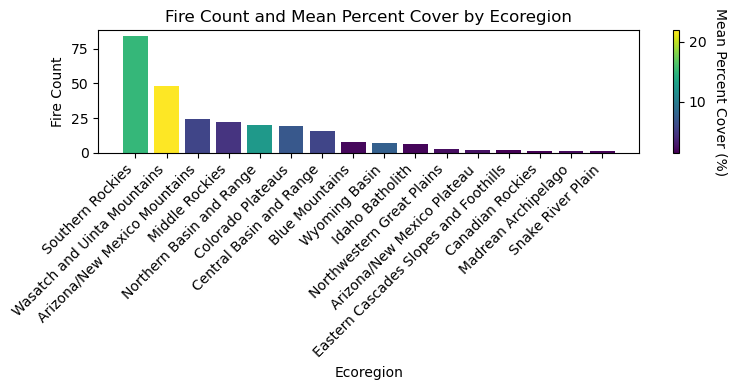

In [144]:
# Plot the count of fires across US EPA Level III ecoregions
df = events_west_aspen.groupby('na_l3name').agg(
    pct_cover_mean=('pct_aspen', 'mean'),  # Mean percent cover
    fire_count=('pct_aspen', 'count')      # Count of fires
).reset_index()

# plot it.
df = df.sort_values('fire_count', ascending=False)

norm = plt.Normalize(df['pct_cover_mean'].min(), df['pct_cover_mean'].max())
cmap = cm.viridis  # Choose a colormap

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(
    df['na_l3name'], 
    df['fire_count'], 
    color=cmap(norm(df['pct_cover_mean']))
)

# Add colorbar for mean percent cover
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Mean Percent Cover (%)', rotation=270, labelpad=15)

# Add labels and title
ax.set_xlabel('Ecoregion')
ax.set_ylabel('Fire Count')
ax.set_title('Fire Count and Mean Percent Cover by Ecoregion')
ax.set_xticks(range(len(df['na_l3name'])))
ax.set_xticklabels(df['na_l3name'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

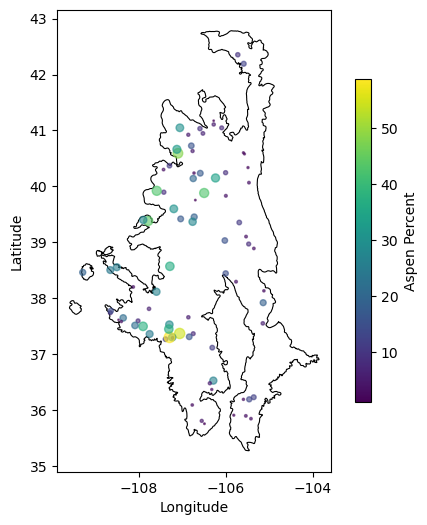

In [147]:
# Southern Rockies map
centroid_srm = centroid[centroid['na_l3name'] == 'Southern Rockies']
ecol3_srm = ecol3[ecol3['na_l3name'] == 'Southern Rockies']

# plot it
fig, ax = plt.subplots(figsize=(6, 6))

ecol3_srm.plot(ax=ax, edgecolor='black', linewidth=0.8, color='none')
centroid_srm.plot(
    ax=ax, markersize=centroid_srm['pct_aspen'], 
    column='pct_aspen', cmap='viridis', 
    legend=False, alpha=0.6)

# Manually add colorbar
norm = matplotlib.colors.Normalize(vmin=centroid_srm['pct_aspen'].min(), vmax=centroid_srm['pct_aspen'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Adjust the size of the colorbar using the `shrink` parameter
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Aspen Percent')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/Figure1_Aspen-Fires_NIFC-SRM_EVT.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
gc.collect()